<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

# Imports

In [1]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git
# !curl "https://drive.usercontent.google.com/download?id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF&confirm=xxx" -o hw2_data.zip
# !unzip -qq hw2_data.zip -d deepul/homeworks/hw2/data
# !pip install ./deepul
from deepul.hw2_helper import *
from deepul import utils as deepul_utils

os.chdir("/nas/ucb/ebronstein/deepul")

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


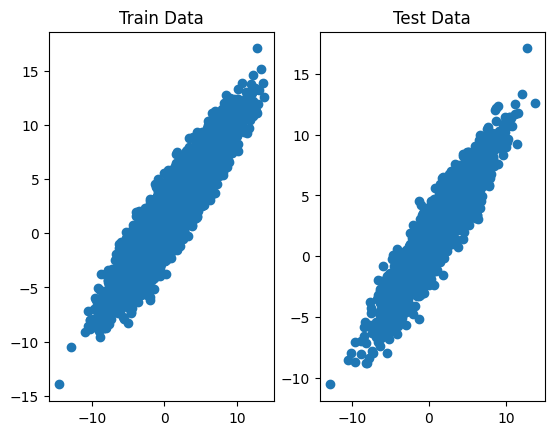

Dataset 2


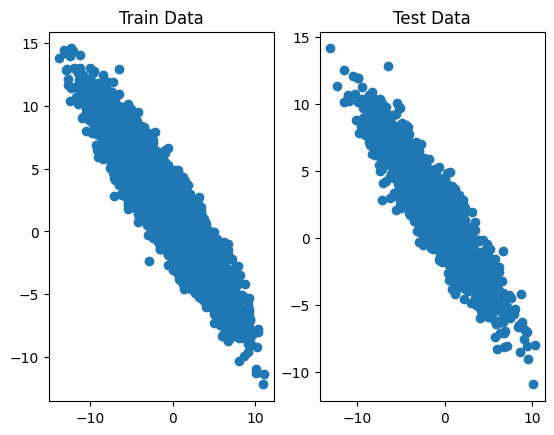

In [2]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [2]:
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt


def make_mlp(input_shape, output_shape, hiddens=None):
    hiddens = hiddens or []
    layers = []
    input_shape = np.prod(input_shape[0])
    for hidden in hiddens:
        layers.append(nn.Linear(input_shape, hidden))
        layers.append(nn.ReLU())
        input_shape = hidden
    layers.append(nn.Linear(input_shape, np.prod(output_shape)))
    return nn.Sequential(*layers)


class VAE(nn.Module):
    def __init__(
        self, input_dim, latent_dim, enc_hidden_sizes=None, dec_hidden_sizes=None
    ):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        enc_hidden_sizes = enc_hidden_sizes or None
        dec_hidden_sizes = dec_hidden_sizes or None

        # Encoder with output 2 * latent_dim for mean and logvar
        self.encoder = make_mlp([input_dim], [2 * latent_dim], enc_hidden_sizes)

        # Decoder with output 2 * input_dim for mean and logvar
        self.decoder = make_mlp([latent_dim], [2 * input_dim], dec_hidden_sizes)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        enc_output = self.encoder(x)
        mu_z, logvar_z = (
            enc_output[:, : self.latent_dim],
            enc_output[:, self.latent_dim :],
        )

        # Reparameterization trick
        z = self.reparameterize(mu_z, logvar_z)

        # Decode
        dec_output = self.decoder(z)
        dec_mean, dec_logvar = (
            dec_output[:, : self.input_dim],
            dec_output[:, self.input_dim :],
        )

        return dec_mean, dec_logvar, mu_z, logvar_z

    def loss(self, dec_mean, dec_logvar, x, mu_z, logvar_z):
        # Compute reconstruction loss using negative log likelihood of x under the normal distribution
        recon_loss = (
            -dist.Normal(dec_mean, torch.exp(0.5 * dec_logvar))
            .log_prob(x)
            .sum(dim=1)
            .mean()
        )

        # KL divergence
        kl_loss = (
            -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp(), dim=1).mean()
        )

        neg_elbo = recon_loss + kl_loss

        return neg_elbo, recon_loss, kl_loss


def train(model, train_loader, optimizer, epoch, verbose=True):
    model.train()
    losses = defaultdict(list)
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        x = batch.cuda()
        dec_mean, dec_logvar, mu_z, logvar = model(x)
        loss, recon_loss, kl_loss = model.loss(dec_mean, dec_logvar, x, mu_z, logvar)
        loss.backward()
        optimizer.step()

        losses["total_loss"].append(loss.item())
        losses["recon_loss"].append(recon_loss.item())
        losses["kl_loss"].append(kl_loss.item())

    if verbose:
        print(
            "====> Epoch: {} avg loss: {:.4f}, average recon loss: {:.4f}, avg KL: {:.4f}".format(
                epoch,
                np.mean(losses["total_loss"][-20:]),
                np.mean(losses["recon_loss"][-20:]),
                np.mean(losses["kl_loss"][-20:]),
            )
        )

    return losses


def test(model, test_loader, verbose=True):
    model.eval()
    losses = defaultdict(int)
    with torch.no_grad():
        for batch in test_loader:
            x = batch.cuda()
            dec_mean, dec_logvar, mu_z, logvar = model(x)
            loss, recon_loss, kl_loss = model.loss(
                dec_mean, dec_logvar, x, mu_z, logvar
            )
            losses["total_loss"] += loss.item() * batch.shape[0]
            losses["recon_loss"] += recon_loss.item() * batch.shape[0]
            losses["kl_loss"] += kl_loss.item() * batch.shape[0]

    for k in losses.keys():
        losses[k] /= len(test_loader.dataset)
    if verbose:
        print("====> Test set loss: {:.4f}".format(losses["total_loss"]))

    return losses


def sample(model, num_samples, add_noise=True):
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).cuda()
        dec_mean, dec_logvar = model.decoder(z).chunk(2, dim=1)
        if add_noise:
            samples = dec_mean + torch.randn_like(dec_mean) * torch.exp(
                0.5 * dec_logvar
            )
        else:
            samples = dec_mean
    return samples.cpu().numpy()


def train_epochs(model, train_loader, test_loader, train_kwargs, verbose=True):
    epochs, lr = train_kwargs["epochs"], train_kwargs["lr"]
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)

    # Evaluate the model before training
    test_loss_dict = test(model, test_loader, verbose=verbose)
    for k in test_loss_dict.keys():
        test_losses[k].append(test_loss_dict[k])

    for epoch in range(epochs):
        train_loss_dict = train(model, train_loader, optimizer, epoch, verbose=verbose)
        test_loss_dict = test(model, test_loader, verbose=verbose)

        for k in train_loss_dict.keys():
            train_losses[k].extend(train_loss_dict[k])
            test_losses[k].append(test_loss_dict[k])

    return train_losses, test_losses

In [7]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """
    epochs = 10
    lr = 1e-3
    verbose = True

    model = VAE(2, 2, [128, 128], [128, 128]).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(
        model, train_loader, test_loader, dict(epochs=epochs, lr=lr), verbose=verbose
    )
    train_losses = np.stack(
        (
            train_losses["total_loss"],
            train_losses["recon_loss"],
            train_losses["kl_loss"],
        ),
        axis=1,
    )
    test_losses = np.stack(
        (test_losses["total_loss"], test_losses["recon_loss"], test_losses["kl_loss"]),
        axis=1,
    )

    num_samples = 1000
    samples_with_noise = sample(model, num_samples, add_noise=True)
    samples_without_noise = sample(model, num_samples, add_noise=False)

    return train_losses, test_losses, samples_with_noise, samples_without_noise

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

====> Test set loss: 15.3799
====> Epoch: 0 avg loss: 5.4282, average recon loss: 5.2078, avg KL: 0.2204
====> Test set loss: 5.4219
====> Epoch: 1 avg loss: 5.1629, average recon loss: 4.4601, avg KL: 0.7029
====> Test set loss: 5.0250
====> Epoch: 2 avg loss: 4.6361, average recon loss: 3.2130, avg KL: 1.4231
====> Test set loss: 4.5450
====> Epoch: 3 avg loss: 4.5452, average recon loss: 3.0033, avg KL: 1.5419
====> Test set loss: 4.4761
====> Epoch: 4 avg loss: 4.5307, average recon loss: 2.9554, avg KL: 1.5753
====> Test set loss: 4.4502
====> Epoch: 5 avg loss: 4.4460, average recon loss: 2.8168, avg KL: 1.6292
====> Test set loss: 4.4590
====> Epoch: 6 avg loss: 4.4650, average recon loss: 2.8832, avg KL: 1.5818
====> Test set loss: 4.4585
====> Epoch: 7 avg loss: 4.4484, average recon loss: 2.8579, avg KL: 1.5905
====> Test set loss: 4.4502
====> Epoch: 8 avg loss: 4.4576, average recon loss: 2.9101, avg KL: 1.5475
====> Test set loss: 4.4984
====> Epoch: 9 avg loss: 4.4751, av

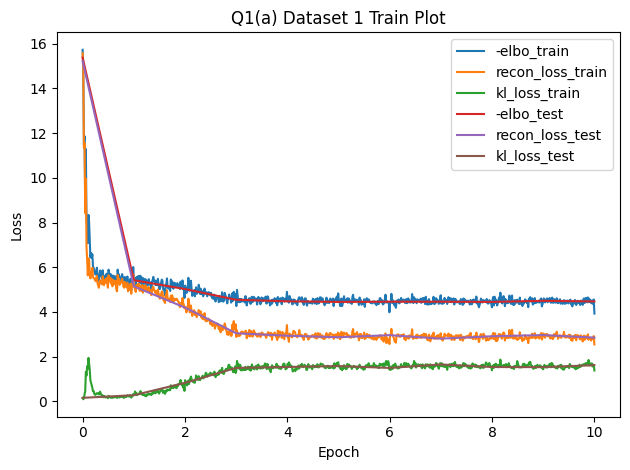

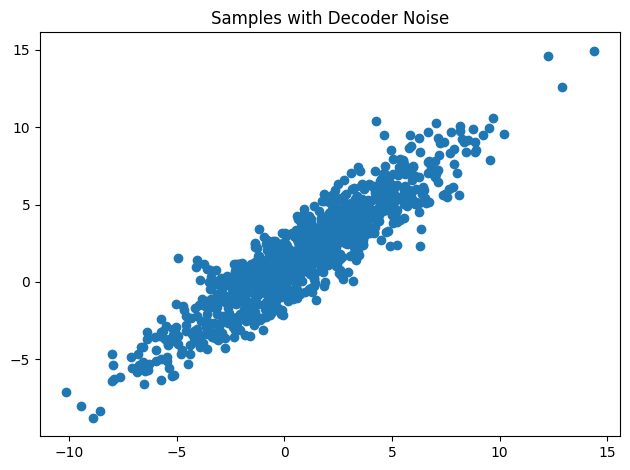

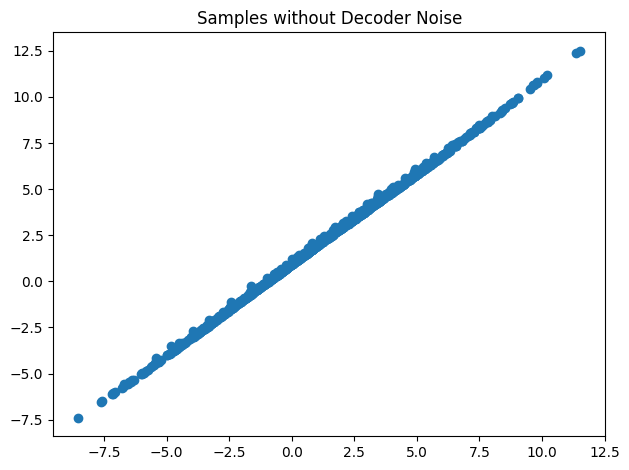

In [23]:
q1_save_results('a', 1, q1)

====> Test set loss: 19.8667
====> Epoch: 0 avg loss: 5.3248, average recon loss: 5.1184, avg KL: 0.2063
====> Test set loss: 5.3541
====> Epoch: 1 avg loss: 5.0297, average recon loss: 4.3550, avg KL: 0.6747
====> Test set loss: 5.0423
====> Epoch: 2 avg loss: 4.7487, average recon loss: 3.4341, avg KL: 1.3145
====> Test set loss: 4.6033
====> Epoch: 3 avg loss: 4.4974, average recon loss: 2.9892, avg KL: 1.5082
====> Test set loss: 4.4677
====> Epoch: 4 avg loss: 4.4714, average recon loss: 2.8891, avg KL: 1.5823
====> Test set loss: 4.4843
====> Epoch: 5 avg loss: 4.5018, average recon loss: 2.9005, avg KL: 1.6013
====> Test set loss: 4.4532
====> Epoch: 6 avg loss: 4.4719, average recon loss: 2.9248, avg KL: 1.5471
====> Test set loss: 4.4272
====> Epoch: 7 avg loss: 4.4399, average recon loss: 2.9011, avg KL: 1.5388
====> Test set loss: 4.4481
====> Epoch: 8 avg loss: 4.4404, average recon loss: 2.8694, avg KL: 1.5710
====> Test set loss: 4.4341
====> Epoch: 9 avg loss: 4.4693, av

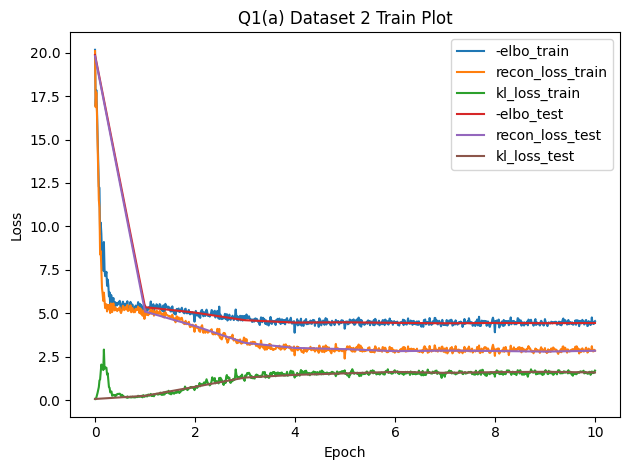

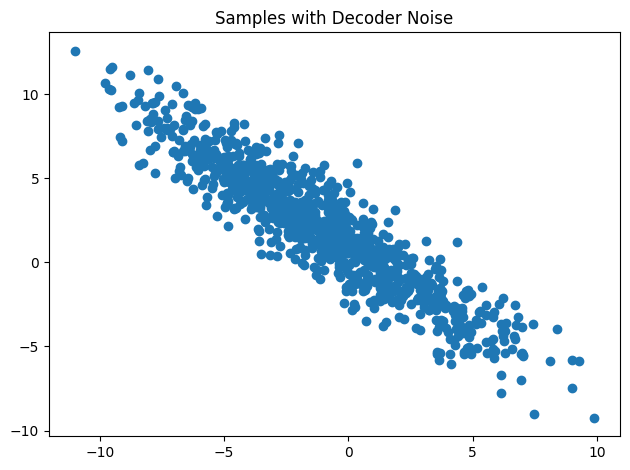

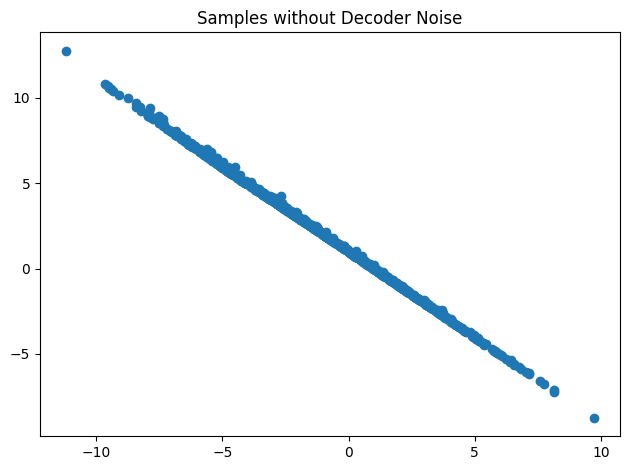

In [24]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


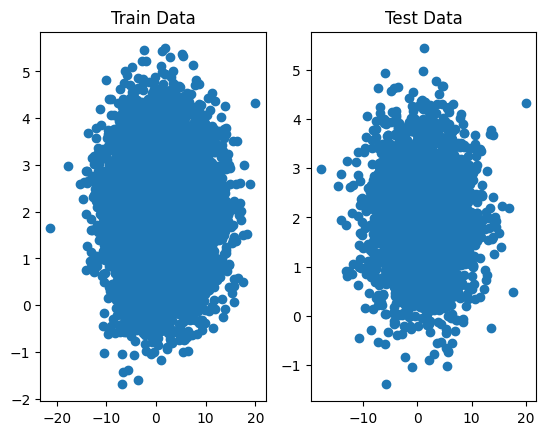

Dataset 2


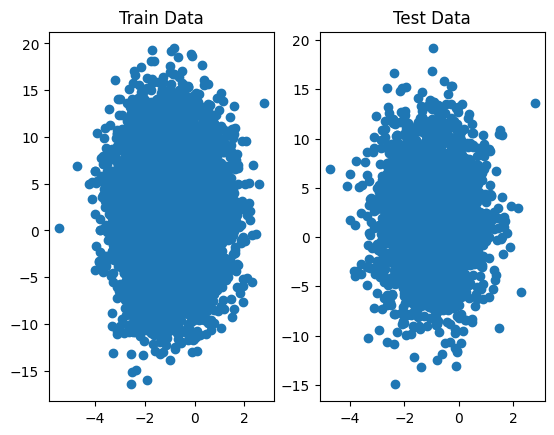

In [25]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

====> Test set loss: 15.0217
====> Epoch: 0 avg loss: 4.5110, average recon loss: 4.4787, avg KL: 0.0323
====> Test set loss: 4.4743
====> Epoch: 1 avg loss: 4.4239, average recon loss: 4.4047, avg KL: 0.0192
====> Test set loss: 4.4323
====> Epoch: 2 avg loss: 4.4291, average recon loss: 4.4150, avg KL: 0.0140
====> Test set loss: 4.4225
====> Epoch: 3 avg loss: 4.4301, average recon loss: 4.4192, avg KL: 0.0109
====> Test set loss: 4.4215
====> Epoch: 4 avg loss: 4.4526, average recon loss: 4.4408, avg KL: 0.0119
====> Test set loss: 4.4250
====> Epoch: 5 avg loss: 4.4433, average recon loss: 4.4317, avg KL: 0.0116
====> Test set loss: 4.4191
====> Epoch: 6 avg loss: 4.4336, average recon loss: 4.4236, avg KL: 0.0100
====> Test set loss: 4.4216
====> Epoch: 7 avg loss: 4.4759, average recon loss: 4.4656, avg KL: 0.0102
====> Test set loss: 4.4248
====> Epoch: 8 avg loss: 4.4374, average recon loss: 4.4242, avg KL: 0.0132
====> Test set loss: 4.4297
====> Epoch: 9 avg loss: 4.4151, av

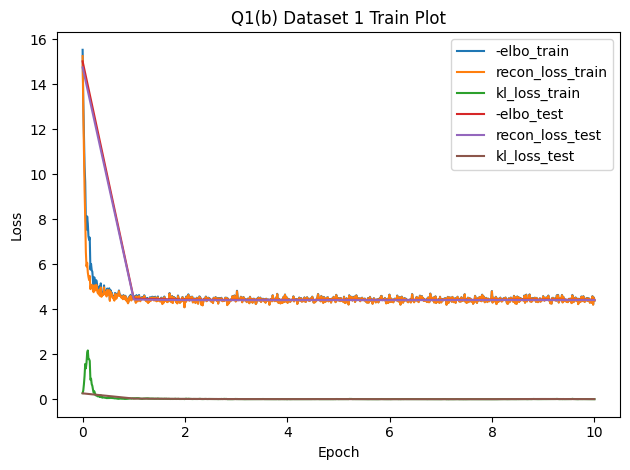

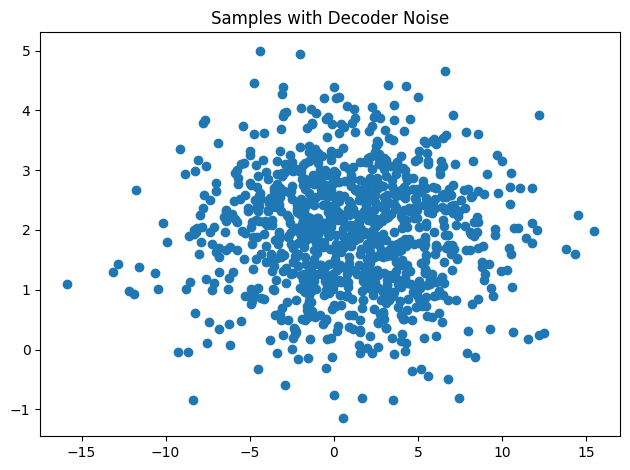

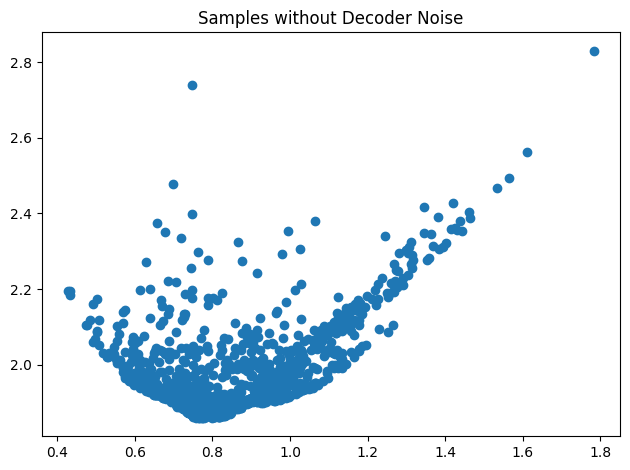

In [26]:
q1_save_results('b', 1, q1)

====> Test set loss: 18.0338
====> Epoch: 0 avg loss: 4.5141, average recon loss: 4.4511, avg KL: 0.0630
====> Test set loss: 4.5390
====> Epoch: 1 avg loss: 4.5106, average recon loss: 4.4528, avg KL: 0.0578
====> Test set loss: 4.4603
====> Epoch: 2 avg loss: 4.4546, average recon loss: 4.4216, avg KL: 0.0329
====> Test set loss: 4.4293
====> Epoch: 3 avg loss: 4.4290, average recon loss: 4.4077, avg KL: 0.0213
====> Test set loss: 4.4257
====> Epoch: 4 avg loss: 4.4460, average recon loss: 4.4317, avg KL: 0.0143
====> Test set loss: 4.4281
====> Epoch: 5 avg loss: 4.4484, average recon loss: 4.4332, avg KL: 0.0151
====> Test set loss: 4.4242
====> Epoch: 6 avg loss: 4.4420, average recon loss: 4.4302, avg KL: 0.0117
====> Test set loss: 4.4243
====> Epoch: 7 avg loss: 4.4248, average recon loss: 4.4173, avg KL: 0.0075
====> Test set loss: 4.4315
====> Epoch: 8 avg loss: 4.4199, average recon loss: 4.4127, avg KL: 0.0072
====> Test set loss: 4.4298
====> Epoch: 9 avg loss: 4.4592, av

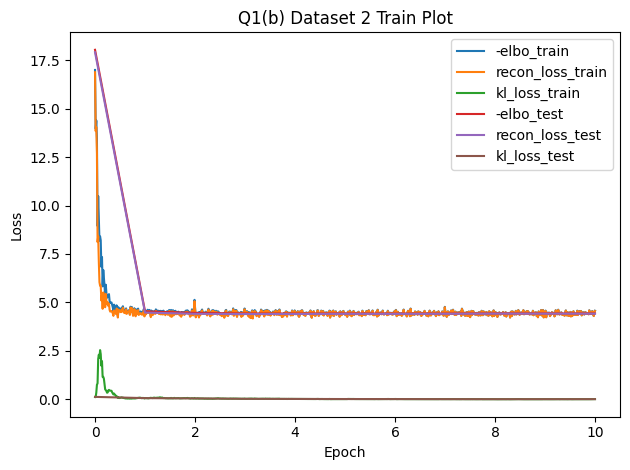

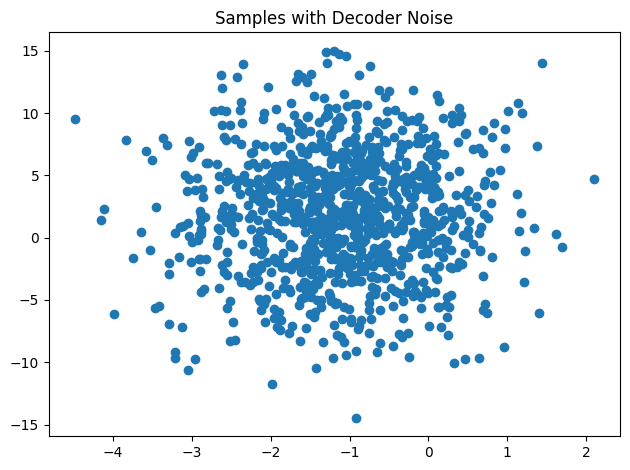

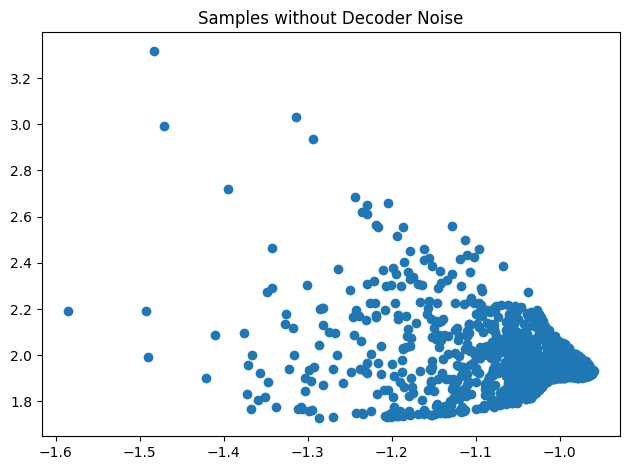

In [27]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

The latents are being used for the datasets in part (a) but not in part (b). Since the data in part(b) comes from a Normal distribution with a diagonal covariate matrix, both the latents and the data are 2D, and latent prior is also a diagonal Gaussian, the latents are not needed to recover the data distribution. The latents can simply be mostly constant, which can be seen from the no-noise samples in part (b) that are mostly clustered around $[-1, 2]$ (i.e., nearm the mean of the data). The learned decoder variance and the samples $\epsilon \sim \cal{N}(0, 1)$ are sufficient to accurately describe the data. In contrast, the dataset in part (b) has a full covariance matrix, so using a constant latent plus a learned covariance times the noise is insufficient to represent it. For this reason, we see that the samples without noise actually look like a de-noised version of the dataset.

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

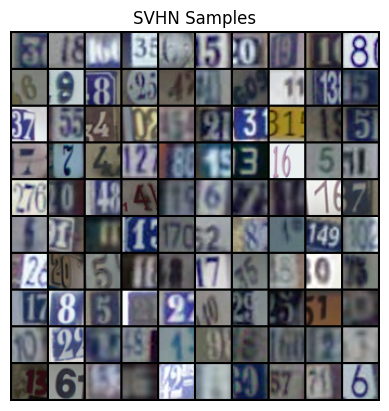

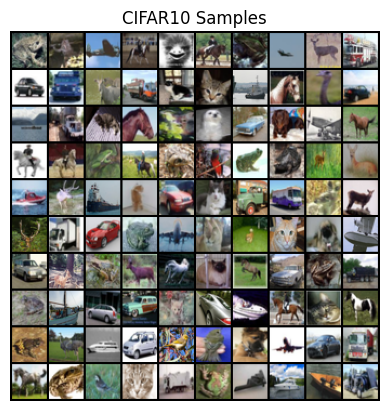

In [5]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [3]:
def normalize_image(x):
    return (x / 255.0).astype(np.float32)


def unnormalize_image(x):
    return (x * 255).astype(np.uint8)


class ImageDecoder(nn.Module):
    def __init__(self, latent_dim, output_shape):
        super().__init__()
        self.latent_dim = latent_dim
        self.output_shape = output_shape
        self.base_img_size = (128, output_shape[1] // 8, output_shape[2] // 8)
        self.linear = nn.Linear(latent_dim, np.prod(self.base_img_size))
        self.model = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, output_shape[0], 3, padding=1),
        )

    def forward(self, z):
        out = self.linear(z)
        out = out.view(out.shape[0], *self.base_img_size)
        return self.model(out)


class ImageEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.model = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
        )
        lin_input_dim = input_shape[1] // 8 * input_shape[2] // 8 * 256
        self.linear = nn.Linear(lin_input_dim, 2 * latent_dim)

    def forward(self, x):
        out = self.model(x)
        out = out.view(out.shape[0], -1)
        mu, log_std = self.linear(out).chunk(2, dim=1)
        return mu, log_std


class ImageVAE(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        assert len(input_shape) == 3
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder = ImageEncoder(input_shape, latent_dim)
        self.decoder = ImageDecoder(latent_dim, input_shape)

    def forward(self, x):
        # Normalize to [-1, 1]
        x = 2 * x - 1

        mu, log_std = self.encoder(x)
        z = mu + torch.randn_like(mu) * log_std.exp()
        # Mean of the reconstructed distribution. Note we do not learn the covariance.
        dec_mean = self.decoder(z)
        dec_log_std = None
        return dec_mean, dec_log_std, mu, log_std

    def loss(self, dec_mean, dec_log_std, x, mu, log_std):
        assert dec_log_std is None

        recon_loss = (
            F.mse_loss(x, dec_mean, reduction="none").view(x.shape[0], -1).sum(1).mean()
        )
        kl_loss = -log_std - 0.5 + (torch.exp(2 * log_std) + mu**2) * 0.5
        kl_loss = kl_loss.sum(1).mean()
        neg_elbo = recon_loss + kl_loss
        return neg_elbo, recon_loss, kl_loss

    def sample(self, n):
        with torch.no_grad():
            z = torch.randn(n, self.latent_dim).cuda()
            samples = torch.clamp(self.decoder(z), -1, 1)
        # Reshape and unnormalize to [0, 1]
        return samples.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5

In [2]:
# TODO: delete this cell

from collections import OrderedDict

from tqdm import tqdm_notebook as tqdm


def train(model, train_loader, optimizer, epoch, quiet, grad_clip=None):
    model.train()

    if not quiet:
        pbar = tqdm(total=len(train_loader.dataset))
    losses = OrderedDict()
    for x in train_loader:
        x = x.cuda()
        out = model.loss(x)
        optimizer.zero_grad()
        out['loss'].backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        desc = f'Epoch {epoch}'
        for k, v in out.items():
            if k not in losses:
                losses[k] = []
            losses[k].append(v.item())
            avg_loss = np.mean(losses[k][-50:])
            desc += f', {k} {avg_loss:.4f}'

        if not quiet:
            pbar.set_description(desc)
            pbar.update(x.shape[0])
    if not quiet:
        pbar.close()
    return losses


def eval_loss(model, data_loader, quiet):
    model.eval()
    total_losses = OrderedDict()
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda()
            out = model.loss(x)
            for k, v in out.items():
                total_losses[k] = total_losses.get(k, 0) + v.item() * x.shape[0]

        desc = 'Test '
        for k in total_losses.keys():
            total_losses[k] /= len(data_loader.dataset)
            desc += f', {k} {total_losses[k]:.4f}'
        if not quiet:
            print(desc)
    return total_losses


def train_epochs(model, train_loader, test_loader, train_args, quiet=False):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = OrderedDict(), OrderedDict()
    for epoch in range(epochs):
        model.train()
        train_loss = train(model, train_loader, optimizer, epoch, quiet, grad_clip)
        test_loss = eval_loss(model, test_loader, quiet)

        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
                test_losses[k] = []
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return train_losses, test_losses


class ConvDecoder(nn.Module):
    def __init__(self, latent_dim, output_shape):
        super().__init__()
        self.latent_dim = latent_dim
        self.output_shape = output_shape

        self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8)
        self.fc = nn.Linear(latent_dim, np.prod(self.base_size))
        self.deconvs = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, output_shape[0], 3, padding=1),
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], *self.base_size)
        out = self.deconvs(out)
        return out


class ConvEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.convs = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
        )
        conv_out_dim = input_shape[1] // 8 * input_shape[2] // 8 * 256
        self.fc = nn.Linear(conv_out_dim, 2 * latent_dim)

    def forward(self, x):
        out = self.convs(x)
        out = out.view(out.shape[0], -1)
        mu, log_std = self.fc(out).chunk(2, dim=1)
        return mu, log_std


class ConvVAE(nn.Module):
    def __init__(self, input_shape, latent_size):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.latent_size = latent_size
        self.encoder = ConvEncoder(input_shape, latent_size)
        self.decoder = ConvDecoder(latent_size, input_shape)

    def forward(self, x):
        x = 2 * x - 1
        mu, log_std = self.encoder(x)
        z = torch.randn_like(mu) * log_std.exp() + mu
        x_recon = self.decoder(z)

        return x_recon, None, mu, log_std

    def loss(self, x_recon, dec_log_std, x, mu, log_std):
        assert dec_log_std is None
        recon_loss = F.mse_loss(x, x_recon, reduction='none').view(x.shape[0], -1).sum(1).mean()
        kl_loss = -log_std - 0.5 + (torch.exp(2 * log_std) + mu ** 2) * 0.5
        kl_loss = kl_loss.sum(1).mean()

        return recon_loss + kl_loss, recon_loss, kl_loss

    def sample(self, n):
        with torch.no_grad():
            z = torch.randn(n, self.latent_size).cuda()
            samples = torch.clamp(self.decoder(z), -1, 1)
        return samples.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5

NameError: name 'nn' is not defined

In [25]:
# def q2_a(train_data, test_data, dset_id):
#     """
#     train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
#     test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
#     dset_id: An identifying number of which dataset is given (1 or 2). Most likely
#                used to set different hyperparameters for different datasets

#     Returns
#     - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
#       and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
#     - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
#       and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
#     - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
#     - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
#       FROM THE TEST SET with values in {0, ..., 255}
#     - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
#       pairs of test images. The output should be those 100 images flattened into
#       the specified shape with values in {0, ..., 255}
#     """
#     epochs = 20
#     lr = 1e-3

#     train_data = normalize_image(train_data)
#     test_data = normalize_image(test_data)
#     train_data = np.transpose(train_data, (0, 3, 1, 2))
#     test_data = np.transpose(test_data, (0, 3, 1, 2))

#     input_shape = train_data.shape[1:]
#     latent_dim = 16
#     model = ImageVAE(input_shape, latent_dim).cuda()

#     train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
#     test_loader = data.DataLoader(test_data, batch_size=128)

#     train_losses, test_losses = train_epochs(
#         model, train_loader, test_loader, dict(epochs=epochs, lr=lr), verbose=True
#     )

#     train_losses = np.stack(
#         (
#             train_losses["total_loss"],
#             train_losses["recon_loss"],
#             train_losses["kl_loss"],
#         ),
#         axis=1,
#     )
#     test_losses = np.stack(
#         (test_losses["total_loss"], test_losses["recon_loss"], test_losses["kl_loss"]),
#         axis=1,
#     )

#     samples = model.sample(100) * 255.0

#     x = next(iter(test_loader))[:50].cuda()
#     with torch.no_grad():
#         # Normalize to [-1, 1]
#         x = 2 * x - 1
#         z, _ = model.encoder(x)
#         x_hat = torch.clamp(model.decoder(z), -1, 1)
#     # Reshape and unnormalize to [0, 1]
#     reconstructions = torch.stack((x, x_hat), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
#     # Unnormalize to [0, 255]
#     reconstructions = unnormalize_image(
#         reconstructions.permute(0, 2, 3, 1).cpu().numpy()
#     )

#     x = next(iter(test_loader))[:20].cuda()
#     with torch.no_grad():
#         # Normalize to [-1, 1]
#         x = 2 * x - 1
#         z, _ = model.encoder(x)
#         # Split the latents into two groups to interpolate between them
#         z1, z2 = z.chunk(2, dim=0)
#         # Linearly interpolate between the two latents and decode
#         interpolations = [
#             model.decoder(z1 * (1 - alpha) + z2 * alpha)
#             for alpha in np.linspace(0, 1, 10)
#         ]
#         # Reshape
#         interpolations = torch.stack(interpolations, dim=1).view(-1, 3, 32, 32)
#         # Unnormalize to [0, 1]
#         interpolations = torch.clamp(interpolations, -1, 1) * 0.5 + 0.5
#     # Unnormalize to [0, 255]
#     interpolations = unnormalize_image(interpolations.permute(0, 2, 3, 1).cpu().numpy())

#     return train_losses, test_losses, samples, reconstructions, interpolations

def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """
    epochs = 10

    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32')

    model = ConvVAE((3, 32, 32), 16).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                             dict(epochs=epochs, lr=1e-3), quiet=False)
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)
    samples = model.sample(100) * 255.

    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        x = 2 * x - 1
        z, _ = model.encoder(x)
        x_recon = torch.clamp(model.decoder(z), -1, 1)
    reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
    reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy() * 255

    x = next(iter(test_loader))[:20].cuda()
    with torch.no_grad():
        x = 2 * x - 1
        z, _ = model.encoder(x)
        z1, z2 = z.chunk(2, dim=0)
        interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
        interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
        interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
    interps = interps.permute(0, 2, 3, 1).cpu().numpy() * 255

    return train_losses, test_losses, samples, reconstructions, interps

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

In [9]:
dset_id = 1
data_dir = deepul_utils.get_data_dir(2)
if dset_id == 1:
    train_data, test_data = deepul_utils.load_pickled_data(join(data_dir, 'svhn.pkl'))
else:
    train_data, test_data = deepul_utils.load_pickled_data(join(data_dir, 'cifar10.pkl'))

In [10]:
train_data.shape

(10000, 32, 32, 3)

In [16]:
epochs = 1
lr = 1e-3
verbose = True

input_shape = train_data.shape[1:]
latent_dim = 16

model = VAE(input_shape, latent_dim, mlp_tower=False).cuda()

normalized_train_data = normalize_image(train_data)
normalized_test_data = normalize_image(test_data)
train_loader = data.DataLoader(normalized_train_data, batch_size=128, shuffle=True)
test_loader = data.DataLoader(normalized_test_data, batch_size=128)
train_losses, test_losses = train_epochs(
    model, train_loader, test_loader, dict(epochs=epochs, lr=lr), verbose=verbose
)
# train_losses = np.stack(
#     (
#         train_losses["total_loss"],
#         train_losses["recon_loss"],
#         train_losses["kl_loss"],
#     ),
#     axis=1,
# )
# test_losses = np.stack(
#     (test_losses["total_loss"], test_losses["recon_loss"], test_losses["kl_loss"]),
#     axis=1,
# )

# num_samples = 1000
# samples_with_noise = sample(model, num_samples, add_noise=True)
# samples_without_noise = sample(model, num_samples, add_noise=False)

# return train_losses, test_losses, samples_with_noise, samples_without_noise

RuntimeError: Input type (double) and bias type (float) should be the same

In [26]:
q2_save_results('a', 1, q2_a)

/tmp/ipykernel_2538117/977695688.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(total=len(train_loader.dataset))


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

====> Test set loss: 947.6207
====> Epoch: 0 avg loss: 101.0390, average recon loss: 90.1768, avg KL: 10.8622
====> Test set loss: 100.7959
====> Epoch: 1 avg loss: 88.5203, average recon loss: 73.5990, avg KL: 14.9214
====> Test set loss: 88.5669
====> Epoch: 2 avg loss: 82.2289, average recon loss: 65.1851, avg KL: 17.0438
====> Test set loss: 81.8029
====> Epoch: 3 avg loss: 80.7589, average recon loss: 63.0817, avg KL: 17.6773
====> Test set loss: 81.4574
====> Epoch: 4 avg loss: 79.1631, average recon loss: 61.5672, avg KL: 17.5958
====> Test set loss: 79.5770
====> Epoch: 5 avg loss: 78.7848, average recon loss: 61.0807, avg KL: 17.7041
====> Test set loss: 78.8406
====> Epoch: 6 avg loss: 79.1462, average recon loss: 61.3587, avg KL: 17.7875
====> Test set loss: 79.4254
====> Epoch: 7 avg loss: 78.1941, average recon loss: 60.3862, avg KL: 17.8079
====> Test set loss: 78.7728
====> Epoch: 8 avg loss: 77.9631, average recon loss: 60.1689, avg KL: 17.7942
====> Test set loss: 78.5

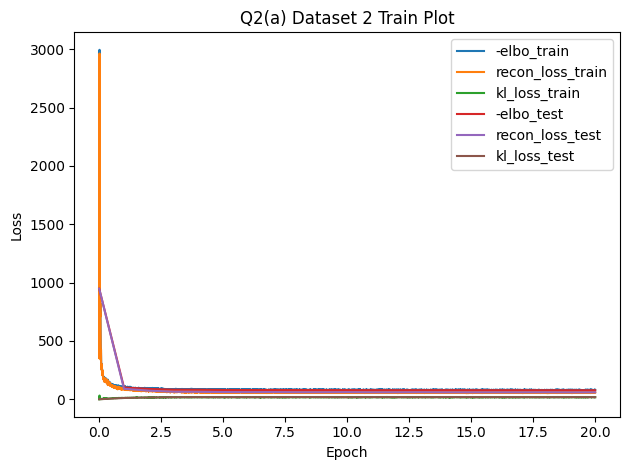

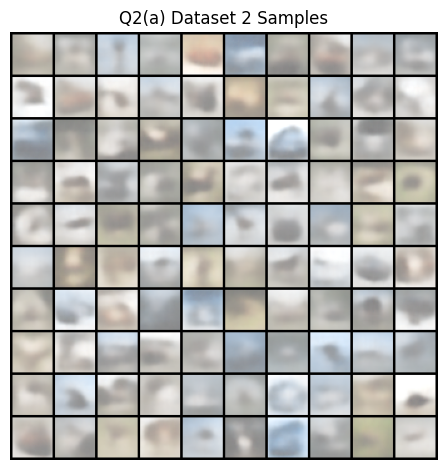

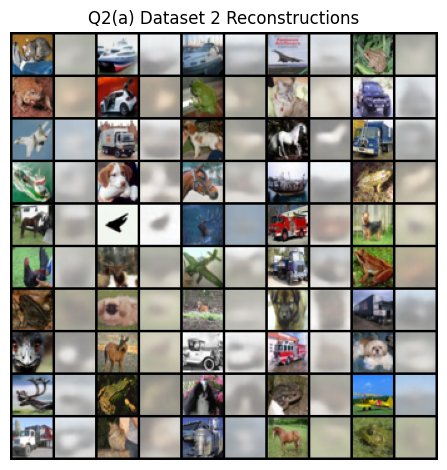

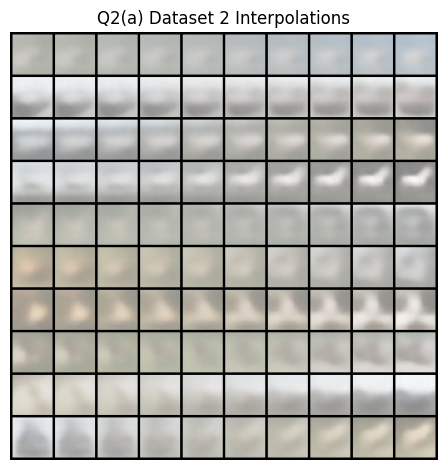

In [31]:
q2_save_results('a', 2, q2_a)

## Part (b) Hierarchical VAE [20pts]

In this part, we will explore a simplified version of the hierarchical VAE described in [NVAE](https://arxiv.org/pdf/2007.03898.pdf). We will not implement the full NVAE, but rather use some ideas from the paper to explore how to learn a prior distribution p(z).

Implement a hierarchical VAE that follows the following structure.
* $z1$ is an 8x8x12 latent vector where p(z1) is the unit Gaussian.
    * Learn the approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix. I.e., same as a normal VAE, but use a matrix latent rather than a vector. Each dimension is independent.
* $z2$ is an 8x8x12 latent vector.
    * $p_\theta(z2|z1)$ is learned, and implemented as a neural network that parameterizes mean (and log std, optionally).
    * $q_\theta(z2|z1,x)$ is also learned. Implement this as a Residual Normal [see NVAE] over the prior $p_\theta(z2|z1)$.
* The decoder should be a function of $z2$ only.

Some helpful hints:
* Two KL losses should be calculated. The first should match $q_\theta(z|x)$ to the unit Gaussian. The second should match $q_\theta(z2|z1,x)$ and $p_\theta(z2|z1)$, and be taken with respect to $q$.
* When calculating the second KL term, utilize the analytic form for the residual normal. When $q_\theta(z2|z1,x) = N(z2; \mu_\theta(z1) + \Delta \mu_\theta(z1,x), \Sigma_\theta(z1)) * \Delta \Sigma_\theta(z1,x))$, use the following form: `kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5`
* When calculating KL, remember to sum over the dimensions of the latent variable before taking the mean over batch.
* For the prior $p_\theta(z2|z1)$, fix standard deviation to be 1. Learn only the mean. This will help with stability in training.

The following network structures may be useful:
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
        nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
        LayerNorm(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 2]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 4]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
We assume encoder networks are of the form p(z'|z,x).
When learning q(z1), an x of all zeros can be used as input.
Upscale z with nearest-neighbor projection before concatenating with x.


Decoder
        nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
        nn.ReLU(),
        nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
```


**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

In [ ]:
q2_save_results('b', 1, q2_b)

In [ ]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a Transformer prior on the categorical latents in order to sample. Feel free to use your implementation for HW1! You should flatten the VQ-VAE tokens into a [H x W] sequence, and use a start token.

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and Transformer prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and Transformer prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples (an equal number from each class) with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

In [ ]:
q3_save_results(1, q3)

In [ ]:
q3_save_results(2, q3)

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)